In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
from DTW import dtwPlotTwoWay, dtw_easy
import random
from tqdm import tqdm

In [2]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [3]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    # plt.figure()
    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
        # plt.plot(signal[begin: end])
    # plt.show()
    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)
    return pieces_padded

In [4]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()


    return [dis12/dis21, A0/A1]

In [5]:
def make_template(piece0, piece1, path):
    path0 = path[0]
    path1 = path[1]
    new_piece0 = np.array([piece0[idx] for idx in path0])
    new_piece1 = np.array([piece1[idx] for idx in path1])

    template = 0.5 * (new_piece0 + new_piece1)
    return template

In [6]:
def performKSC(pieces):
    n, dim = pieces.shape

    matrix = np.zeros((dim, dim))

    for piece in pieces:
        norm_2 = np.linalg.norm(piece, 2)
        matrix += (np.eye(dim) -  piece @ piece.T / norm_2)

        # 计算矩阵的特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    # 找到最小特征值的索引
    min_eigenvalue_index = np.argmin(eigenvalues)

    # 提取对应的最小特征值和特征向量
    _ = eigenvalues[min_eigenvalue_index]
    min_eigenvector = eigenvectors[:, min_eigenvalue_index]
    # print(matrix)
    return min_eigenvector

In [9]:
def extract_dtw(signals, labels, alpha,  h, d, echo):
    KSC_features = []
    idxs = []

    for cnt, signal in tqdm(enumerate(signals)):
        hr = labels[cnt, 2]
        large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
        pieces = segmentation(signal, large_peaks)
        # print(pieces.shape)
        template = performKSC(pieces)

        plt.figure()
        plt.plot(template)
        plt.title('Centroid of Templates')
        plt.show()

        if cnt > echo:
            break
    return np.array(KSC_features), np.array(idxs)


In [10]:
def std_2d(matrix):
    mean_values = np.mean(matrix, axis=1, keepdims=True)
    std_dev_values = np.std(matrix, axis=1, keepdims=True)
    print(std_dev_values.shape)
    # 使用Z标准化公式进行标准化
    z_standardized_matrix = (matrix - mean_values) / std_dev_values
    return z_standardized_matrix

(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


0it [00:00, ?it/s]D:\ANACONDA\envs\pytorch\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


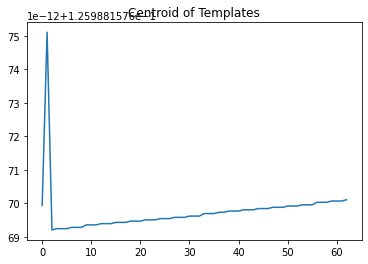

1it [00:00,  3.45it/s]

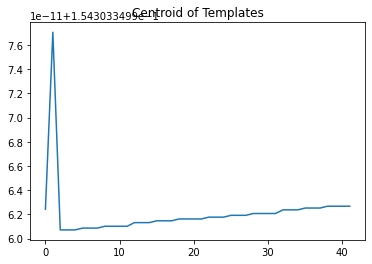

2it [00:00,  4.80it/s]

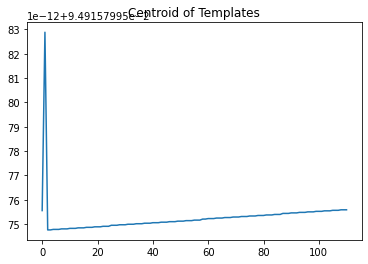

3it [00:00,  5.41it/s]

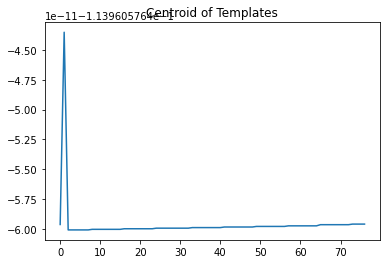

4it [00:00,  4.94it/s]

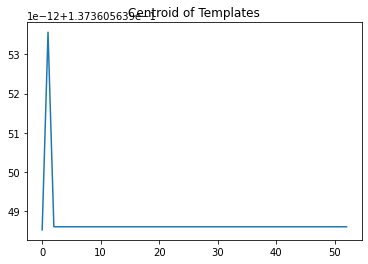

4it [00:00,  4.06it/s]
0it [00:00, ?it/s]

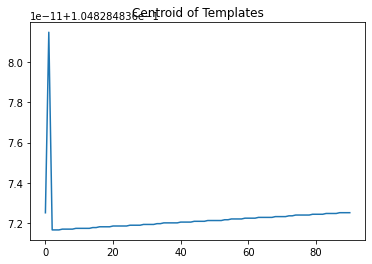

1it [00:00,  7.07it/s]

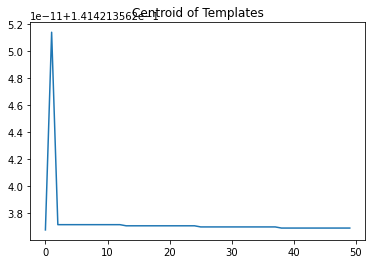

2it [00:00,  6.19it/s]

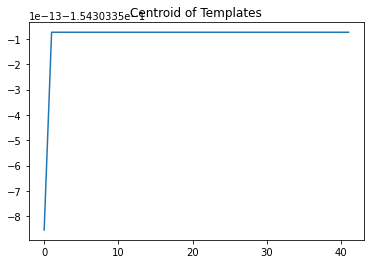

3it [00:00,  6.33it/s]

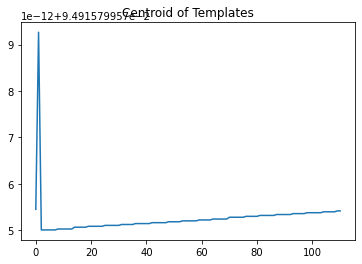

4it [00:00,  6.69it/s]

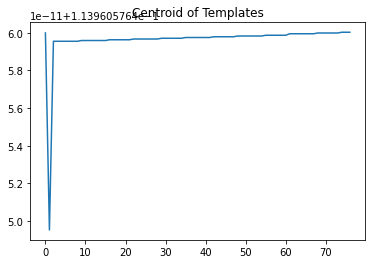

4it [00:00,  5.28it/s]


In [11]:
if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    echo1, echo2 = 3, 3
    KSC_features_train, idxs_train = extract_dtw(signals_0_train,labels_0_train, 1, 0.1, 0.15, echo1)
    KSC_features_test, idxs_test = extract_dtw(signals_0_test, labels_0_test, 1, 0.12, 0.12, echo2)